In [114]:
# Importing Tools
import pandas
import matplotlib as mat
import numpy
import seaborn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import collections

# Statistical Methods
from sklearn.metrics import silhouette_score, precision_recall_curve, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import PowerTransformer, LabelEncoder, StandardScaler, OrdinalEncoder

# PCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# SMOTE Importing
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC
from imblearn.combine import SMOTEENN

# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Importing Tools
from sklearn.metrics import classification_report

# Balancing Models
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

# Outlier Detection tool
from sklearn.ensemble import IsolationForest

# CATboost Classification
from catboost import CatBoostClassifier, Pool

In [115]:
def convert_Xtrain(data_var):

    # Saving encoders for specific columns
    lbEncoder = {}
    scEncoder = {}
    prEncoder = {}

    if not data_var.empty:

        catData = data_var.select_dtypes(include=['bool', 'object'])
        numData = data_var.select_dtypes(include=['int', 'float'])

        # First Categorical Data
        catCol = catData.columns

        for eachColumn in catCol:

            # Fitting the method
            encoder = LabelEncoder()
            new_Column_Value = encoder.fit_transform(catData[eachColumn])
            lbEncoder[eachColumn] = encoder

            # Scaling the encoded ones
            scaler = StandardScaler()
            scaled_New_values = scaler.fit_transform(pandas.DataFrame(new_Column_Value, columns=[eachColumn]))
            scEncoder[eachColumn] = scaler

            # Passing it to the respective column
            catData[eachColumn] = scaled_New_values.flatten()

            # Transferring each transformers

        # Second Continous Data
        numCol = numData.columns

        for eachColumns in numCol:

            # Power Transformer
            columnMean = numData[eachColumns].mean()
            columnMedian = numData[eachColumns].median()

            # This transformer handles the skewness of the data as well as
            # It scales down the columns. So no need to use any transformation method
            if columnMean > columnMedian:
                
                # When the data is right skewed
                transformer = PowerTransformer(method='yeo-johnson')
                numScaledValues = transformer.fit_transform(pandas.DataFrame(numData[eachColumns], columns=[eachColumns]))
                numData[eachColumns] = numScaledValues
            
            elif columnMean < columnMedian:

                # When the data is left skewed
                transformer = PowerTransformer(method='yeo-johnson')
                numScaledValues = transformer.fit_transform(pandas.DataFrame(numData[eachColumns], columns=[eachColumns]))
                numData[eachColumns] = numScaledValues
            

            # Transferring the transformer
            prEncoder[eachColumns] = transformer

        # Concatenating both the data
        concat_data = pandas.DataFrame(
            pandas.concat([catData, numData], axis=1)
        )

        return concat_data, lbEncoder, scEncoder, prEncoder

    else:
        return 'please pass the data in this function'

In [116]:
# Second function for X test
def convert_Xtest(data_var, encoders_cat, scalers_num, transformers_num):
    
    X = data_var.copy()

    # ---- 1) CATEGORICAL FEATURES ----
    for col, enc in (encoders_cat or {}).items():
        if col not in X.columns:
            continue
        # Preferred: sklearn OrdinalEncoder fitted with handle_unknown
        if hasattr(enc, "transform") and hasattr(enc, "categories_"):  # OrdinalEncoder
            # OrdinalEncoder expects 2D
            
            X[col] = enc.transform(X[[col]])
        else:
            # Fallback for LabelEncoder: map unknown to -1 (no exception)
            # NOTE: LabelEncoder is NOT recommended for features
            classes = set(getattr(enc, "classes_", []))
            mapping = {cls: i for i, cls in enumerate(getattr(enc, "classes_", []))}
            X[col] = X[col].map(lambda v: mapping.get(v, -1)).astype("int64")

    # ---- 2) NUMERIC SCALERS ----
    for col, scaler in (scalers_num or {}).items():
        if col not in X.columns:
            continue
        X[col] = scaler.transform(X[[col]])

    # ---- 3) OTHER NUMERIC TRANSFORMS ----
    for col, transf in (transformers_num or {}).items():
        if col not in X.columns:
            continue
        X[col] = transf.transform(X[[col]])

    return X
        

# Calling updated data

In [117]:
data = pandas.read_csv(r'D:\data\updated_customer_sentiment.csv')

pandas.set_option('display.max_columns', None)


In [118]:
# Adding additional columns ---> Feature Engineering

eps = 1e-9

# --- Entropy based ---
p_adm = data["Administrative"] / (data["totalPagesViewed"] + 1)
p_inf = data["Informational"] / (data["totalPagesViewed"] + 1)
p_prd = data["ProductRelated"] / (data["totalPagesViewed"] + 1)
data["pageTypeEntropy"] = -(p_adm*numpy.log(p_adm+eps) + 
                               p_inf*numpy.log(p_inf+eps) + 
                               p_prd*numpy.log(p_prd+eps))

q_adm = data["Administrative_Duration"] / (data["totalDuration"] + 1)
q_inf = data["Informational_Duration"] / (data["totalDuration"] + 1)
q_prd = data["ProductRelated_Duration"] / (data["totalDuration"] + 1)
data["timeShareEntropy"] = -(q_adm*numpy.log(q_adm+eps) +
                                q_inf*numpy.log(q_inf+eps) +
                                q_prd*numpy.log(q_prd+eps))

# Dominant page type
ratios = pandas.concat([p_adm, p_inf, p_prd], axis=1)
ratios.columns = ["adminRatio","infoRatio","prodRatio"]
data["dominantPageType"] = ratios.idxmax(axis=1)

# Distinct types touched
data["numPageTypesTouched"] = ((data["Administrative"]>0).astype(int) + 
                                  (data["Informational"]>0).astype(int) + 
                                  (data["ProductRelated"]>0).astype(int))

# --- Efficiency / intent ---
data["viewsPerMinute"] = data["totalPagesViewed"] / (data["totalDuration"]/60 + 1)
data["productViewsPerMinute"] = data["ProductRelated"] / (data["totalDuration"]/60 + 1)

data["valuePerSecond"] = data["PageValues"] / (data["totalDuration"] + 1)
data["valuePerProductSecond"] = data["PageValues"] / (data["ProductRelated_Duration"] + 1)
data["valuePerProductView"] = data["PageValues"] / (data["ProductRelated"] + 1)

data["avgTimeProduct"] = data["ProductRelated_Duration"] / (data["ProductRelated"] + 1)
data["avgTimeNonProduct"] = (data["Administrative_Duration"] + data["Informational_Duration"]) / (
                                data["Administrative"] + data["Informational"] + 1)
data["productVsNonProductAvgTimeRatio"] = data["avgTimeProduct"] / (data["avgTimeNonProduct"] + eps)

data["touchAllSections"] = ((data["Administrative"]>0) &
                               (data["Informational"]>0) &
                               (data["ProductRelated"]>0)).astype(int)
data["quickSkim"] = ((data["totalDuration"] < 30) & 
                        (data["totalPagesViewed"] <= 2)).astype(int)

    # --- Bounce/Exit ---
data["bounceExitRatio"] = data["BounceRates"] / (data["ExitRates"] + eps)
data["exitPenalizedValue"] = data["PageValues"] * (1 - data["ExitRates"])
data["highBounceLowFocus"] = ((data["BounceRates"] > 0.8) & 
                                 (data["productFocus"] < 0.3))

    # --- Calendar / cohort interactions ---
data["specialDay_productTime"] = data["SpecialDay"] * data["productTimeRatio"]
data["weekend_productFocus"] = data["Weekend"].astype(int) * data["productFocus"]
data["returning_productFocus"] = (data["VisitorType"]=="Returning_Visitor").astype(int) * data["productFocus"]
data["holidaySeason"] = data["monthNum"].isin([11,12]).astype(int)
data["quarterEnd"] = data["monthNum"].isin([3,6,9,12]).astype(int)

    # --- Robust transforms ---
for col in ["totalDuration","avgTimePerPage","PageValues","timeToValueRatio"]:
    data[f"{col}_log"] = numpy.log1p(data[col])
    data[f"{col}_sqrt"] = numpy.sqrt(data[col].clip(lower=0))

    # --- Composite indices ---
val_norm = data["valuePerSecond"] / (numpy.percentile(data["valuePerSecond"],95) + eps)
data["intentIndex"] = (0.45*data["productFocus"] +
                          0.25*val_norm +
                          0.15*(1-data["BounceRates"]) +
                          0.15*(1-data["ExitRates"]))

data["frictionIndex"] = 0.5*(data["bounceExitRatio"] / (numpy.percentile(data["bounceExitRatio"],95)+eps)) + \
                           0.5*(data["Administrative_Duration"] / (data["totalDuration"]+1))

In [119]:
# Classification Report Generator
def getClassified(y_train, y_test, train_predict, test_predict):

    train = pandas.DataFrame(
        classification_report(y_train, train_predict, output_dict=True)
    )

    test = pandas.DataFrame(
        classification_report(y_test, test_predict, output_dict=True)
    )

    return train, test

------> Unbalanced data found


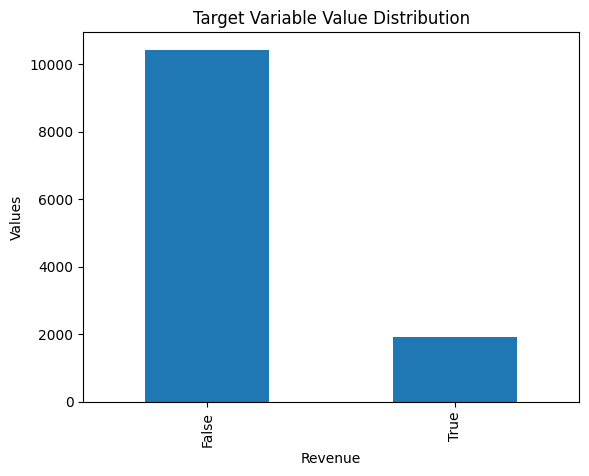

In [120]:
# Plotting Target Variable
distribution = data['Revenue'].value_counts()

# First plot
distribution.plot(kind='bar')
mat.pyplot.title('Target Variable Value Distribution')
mat.pyplot.ylabel('Values')

print('------> Unbalanced data found')

In [121]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,totalPagesViewed,totalDuration,avgTimePerPage,hasLongSession,productFocus,productTimeRatio,isBounce,isExit,adminPageRatio,infoPageRatio,adminTimeRatio,infoTimeRatio,pageValuePerView,engagementScore,monthNum,season,isHighValueVisitor,timeToValueRatio,weekendHighEngagement,pageTypeEntropy,timeShareEntropy,dominantPageType,numPageTypesTouched,viewsPerMinute,productViewsPerMinute,valuePerSecond,valuePerProductSecond,valuePerProductView,avgTimeProduct,avgTimeNonProduct,productVsNonProductAvgTimeRatio,touchAllSections,quickSkim,bounceExitRatio,exitPenalizedValue,highBounceLowFocus,specialDay_productTime,weekend_productFocus,returning_productFocus,holidaySeason,quarterEnd,totalDuration_log,totalDuration_sqrt,avgTimePerPage_log,avgTimePerPage_sqrt,PageValues_log,PageValues_sqrt,timeToValueRatio_log,timeToValueRatio_sqrt,intentIndex,frictionIndex
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.000000,0.000000,MayBe,Yes,0.000000,0.0,0.000000,0.0,0.000000,0.133333,2,Winter,No,0.000000e+00,No,0.346574,0.000000,prodRatio,1,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000e+00,0,1,1.000000,0.000000,False,0.0,0.000000,1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.500000
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,2,64.000000,32.000000,No,1.000000,1.000000,No,Yes,0.000000,0.0,0.000000,0.0,0.000000,0.167033,2,Winter,No,6.400000e+07,No,0.270310,0.015266,prodRatio,1,0.967742,0.967742,0.000000,0.000000,0.000000,21.333333,0.00,2.133333e+10,0,0,0.000000,0.000000,False,0.0,0.000000,1.000000,0,0,4.174387,8.000000,3.496508,5.656854,0.000000,0.000000,17.974394,8000.000000,0.735000,0.000000
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.000000,0.000000,MayBe,Yes,0.000000,0.0,0.000000,0.0,0.000000,0.133333,2,Winter,No,0.000000e+00,No,0.346574,0.000000,prodRatio,1,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000e+00,0,1,1.000000,0.000000,False,0.0,0.000000,1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.500000
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2,2.666667,1.333333,No,1.000000,1.000000,No,Yes,0.000000,0.0,0.000000,0.0,0.000000,0.158349,2,Winter,No,2.666667e+06,No,0.270310,0.231603,prodRatio,1,1.914894,1.914894,0.000000,0.000000,0.000000,0.888889,0.00,8.888889e+08,0,1,0.357143,0.000000,False,0.0,0.000000,1.000000,0,0,1.299283,1.632993,0.847298,1.154701,0.000000,0.000000,14.796340,1632.993162,0.721500,0.178571
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,10,627.500000,62.750000,No,1.000000,1.000000,No,Yes,0.000000,0.0,0.000000,0.0,0.000000,0.166923,2,Winter,No,6.275000e+08,No,0.086646,0.001590,prodRatio,1,0.872727,0.872727,0.000000,0.000000,0.000000,57.045455,0.00,5.704545e+10,0,0,0.400000,0.000000,False,0.0,1.000000,1.000000,0,0,6.443336,25.049950,4.154969,7.921490,0.000000,0.000000,20.257254,25049.950100,0.739500,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False,56,1928.791667,34.442708,Yes,0.946429,0.924823,No,No,0.053571,0.0,0.075177,0.0,0.218602,0.190046,12,Winter,Yes,1.575589e+02,Yes,0.222624,0.267208,prodRatio,2,1.689468,1.5989

In [122]:

kNeigh = [2, 3, 5, 7]

# Data
X = data.drop(columns=['Revenue'])
y = data['Revenue']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=47, test_size=0.1, stratify=y
)

# Converting the train and test dataset
new_x, lbEncoder, stdScaler, powerTransf = convert_Xtrain(X_train)
xColumns = new_x.columns
new_xTest = convert_Xtest(X_test, lbEncoder, stdScaler, powerTransf)[xColumns]

# SMOTE
smote = SMOTE(random_state=53, sampling_strategy='not minority', k_neighbors=3)

# Applying on training set
X_train_s, y_train_s = smote.fit_resample(new_x, y_train)

# Class weights
logistic = LogisticRegression(penalty='l2', max_iter=300, random_state=47, intercept_scaling=0.3)
logistic.fit(X_train_s, y_train_s)

# Predicting
predictTraining = logistic.predict(X_train_s)
predictTesting = logistic.predict(new_xTest)

# evaluation
training, testing = getClassified(y_train_s, y_test, predictTraining, predictTesting)

In [123]:
# Logistic Training set
training

,False,True,accuracy,macro avg,weighted avg
precision,0.931461,0.713900,0.902406,0.822681,0.897799
recall,0.954797,0.616191,0.902406,0.785494,0.902406
f1-score,0.942985,0.661457,0.902406,0.802221,0.899425
support,9380.000000,1717.000000,0.902406,11097.000000,11097.000000


In [124]:
# Logistic Testing Set
testing

,False,True,accuracy,macro avg,weighted avg
precision,0.924563,0.746575,0.903487,0.835569,0.896992
recall,0.964491,0.570681,0.903487,0.767586,0.903487
f1-score,0.944105,0.646884,0.903487,0.795495,0.898064
support,1042.000000,191.000000,0.903487,1233.000000,1233.000000


In [125]:
# Logistic Regression With Balanced Parameter
balancedLog = LogisticRegression(class_weight='balanced', max_iter=500)
balancedLog.fit(new_x, y_train)

# Predict
trained = balancedLog.predict(new_x)
tested = balancedLog.predict(new_xTest)

# Classification Report
train, test = getClassified(y_train = y_train, y_test = y_test, train_predict= trained, test_predict = tested)

In [126]:
train

,False,True,accuracy,macro avg,weighted avg
precision,0.969106,0.543454,0.86627,0.756280,0.903247
recall,0.869510,0.848573,0.86627,0.859041,0.866270
f1-score,0.916610,0.662574,0.86627,0.789592,0.877304
support,9380.000000,1717.000000,0.86627,11097.000000,11097.000000


In [127]:
test

,False,True,accuracy,macro avg,weighted avg
precision,0.959831,0.533101,0.860503,0.746466,0.893728
recall,0.871401,0.801047,0.860503,0.836224,0.860503
f1-score,0.913481,0.640167,0.860503,0.776824,0.871143
support,1042.000000,191.000000,0.860503,1233.000000,1233.000000


# Gradient Boosting

In [128]:
# Gradient Boosting

parameter_grid = {
    'learning_rate': [0.03],
    'n_estimators': [500],
    'subsample': [0.9],
    'max_depth': [4],
    'min_samples_leaf': [2]
}

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=43)

gradient = GridSearchCV(
    GradientBoostingClassifier(random_state=43, n_iter_no_change=10), param_grid= parameter_grid, cv = cv, n_jobs=4, refit=True, return_train_score=True
)
gradient.fit(X_train_s, y_train_s)

# Prediction
trainingGradientPrediction = gradient.predict(X_train_s)
gradientPrediction = gradient.predict(new_xTest)

# Classification Report
training = pandas.DataFrame(
    classification_report(y_train_s, trainingGradientPrediction, output_dict=True)
)

testing = pandas.DataFrame(
    classification_report(y_test, gradientPrediction, output_dict=True)
)

In [129]:
training

,False,True,accuracy,macro avg,weighted avg
precision,0.937082,0.806569,0.92097,0.871826,0.916889
recall,0.971748,0.643564,0.92097,0.807656,0.920970
f1-score,0.954101,0.715905,0.92097,0.835003,0.917245
support,9380.000000,1717.000000,0.92097,11097.000000,11097.000000


In [130]:
testing

,False,True,accuracy,macro avg,weighted avg
precision,0.930211,0.798611,0.914842,0.864411,0.909825
recall,0.972169,0.602094,0.914842,0.787132,0.914842
f1-score,0.950727,0.686567,0.914842,0.818647,0.909807
support,1042.000000,191.000000,0.914842,1233.000000,1233.000000


In [131]:
# Random Forest Balanced
balancedRM = BalancedRandomForestClassifier(
    n_estimators=400,
    max_depth = 3,
    min_samples_leaf= 5,
    min_samples_split= 3,
    max_leaf_nodes= 2,
    sampling_strategy='not minority'
)

balancedRM.fit(X_train_s, y_train_s)

# Prediction
trainedRm = balancedRM.predict(X_train_s)
testedRm = balancedRM.predict(new_xTest)

train, test = getClassified(y_train_s, y_test, trainedRm, testedRm)

In [132]:
train

,False,True,accuracy,macro avg,weighted avg
precision,0.961547,0.562322,0.872939,0.761935,0.899777
recall,0.885075,0.806639,0.872939,0.845857,0.872939
f1-score,0.921728,0.662679,0.872939,0.792203,0.881646
support,9380.000000,1717.000000,0.872939,11097.000000,11097.000000


In [133]:
test

,False,True,accuracy,macro avg,weighted avg
precision,0.960663,0.573034,0.876723,0.766848,0.900616
recall,0.890595,0.801047,0.876723,0.845821,0.876723
f1-score,0.924303,0.668122,0.876723,0.796213,0.884619
support,1042.000000,191.000000,0.876723,1233.000000,1233.000000


In [134]:
# Ada Boost
adaBoost = EasyEnsembleClassifier(
    n_estimators=3,
    random_state=53,
    estimator=gradient,
    sampling_strategy='not majority',
    n_jobs=6
)

adaBoost.fit(new_x, y_train)

train = adaBoost.predict(new_x)
test = adaBoost.predict(new_xTest)

train, test = getClassified(y_train, y_test, train, test)

In [135]:
train

,False,True,accuracy,macro avg,weighted avg
precision,0.938324,0.807220,0.921961,0.872772,0.918039
recall,0.971535,0.651136,0.921961,0.811335,0.921961
f1-score,0.954641,0.720825,0.921961,0.837733,0.918463
support,9380.000000,1717.000000,0.921961,11097.000000,11097.000000


In [136]:
test

,False,True,accuracy,macro avg,weighted avg
precision,0.926807,0.792857,0.911598,0.859832,0.906057
recall,0.972169,0.581152,0.911598,0.776660,0.911598
f1-score,0.948946,0.670695,0.911598,0.809820,0.905843
support,1042.000000,191.000000,0.911598,1233.000000,1233.000000


In [137]:
# Calling Catboost
# Train test split

# 1) Split (stratify keeps class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) Identify column types
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# 3) Ordinal-encode cats (fit on TRAIN only)
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
Xtr_cat = enc.fit_transform(X_train[cat_cols])  
Xte_cat = enc.transform(X_test[cat_cols])

Xtr_num = X_train[num_cols].to_numpy(dtype=float)
Xte_num = X_test[num_cols].to_numpy(dtype=float)

# Put encoded cats first, then numerics (so SMOTENC knows their indices)
Xtr_enc = numpy.hstack([Xtr_cat, Xtr_num])
Xte_enc = numpy.hstack([Xte_cat, Xte_num])

cat_indices = list(range(len(cat_cols)))  # categorical columns' positions in Xtr_enc

# 4) SMOTENC on TRAIN only (no leakage)
sm = SMOTENC(categorical_features=cat_indices, random_state=45,
             sampling_strategy=0.25, k_neighbors=5)
Xtr_res, ytr_res = sm.fit_resample(Xtr_enc, y_train.values)

# 5) Train CatBoost WITHOUT cat_features (since we pass arrays)
train_pool = Pool(Xtr_res, ytr_res)
test_pool  = Pool(Xte_enc, y_test)

catBoost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    learning_rate= 0.001,
    depth= 4,
    l2_leaf_reg=2.5,
    iterations=2000,
    random_state=42,
    verbose=True
)

catBoost.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    early_stopping_rounds=200
)

Xtr_enc_tr, Xtr_enc_val, ytr_tr, ytr_val = train_test_split(
    Xtr_enc, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Predict probabilities on that validation slice using the trained model
val_proba = catBoost.predict_proba(Pool(Xtr_enc_val))[:, 1]

# Pick threshold that maximizes F1 on validation
ps, rs, ths = precision_recall_curve(ytr_val, val_proba)
f1s = (2*ps*rs)/(ps+rs+1e-12)
best_i = int(numpy.nanargmax(f1s))
best_t = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
print("Chosen threshold from validation:", best_t)

# 2) Evaluate on TEST with that threshold (this is your honest score)
test_proba = catBoost.predict_proba(Pool(Xte_enc))[:, 1]
test_pred  = (test_proba >= best_t).astype(int)

print("Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Test PR  AUC:", average_precision_score(y_test, test_proba))
print("\nClassification report (Test):")
print(classification_report(y_test, test_pred, target_names=["No Revenue","Revenue"]))
print("\nConfusion matrix (Test):\n", confusion_matrix(y_test, test_pred))

# 3) (Optional) If you still want a "train" metric, evaluate on ORIGINAL train (pre-SMOTE):
train_proba_orig = catBoost.predict_proba(Pool(Xtr_enc))[:, 1]
train_pred_orig  = (train_proba_orig >= best_t).astype(int)
print("\nClassification report (Train, original non-resampled):")
print(classification_report(y_train, train_pred_orig, target_names=["No Revenue","Revenue"]))

evals = catBoost.get_evals_result()

# Keys
print(evals.keys())

0:	test: 0.8650840	best: 0.8650840 (0)	total: 14.5ms	remaining: 29.1s
1:	test: 0.8731428	best: 0.8731428 (1)	total: 28.2ms	remaining: 28.2s
2:	test: 0.8769087	best: 0.8769087 (2)	total: 39.8ms	remaining: 26.5s
3:	test: 0.8804567	best: 0.8804567 (3)	total: 51ms	remaining: 25.5s
4:	test: 0.8774721	best: 0.8804567 (3)	total: 60ms	remaining: 23.9s
5:	test: 0.8828339	best: 0.8828339 (5)	total: 69.3ms	remaining: 23s
6:	test: 0.8802544	best: 0.8828339 (5)	total: 76.4ms	remaining: 21.7s
7:	test: 0.8831291	best: 0.8831291 (7)	total: 83.3ms	remaining: 20.7s
8:	test: 0.8926821	best: 0.8926821 (8)	total: 89.4ms	remaining: 19.8s
9:	test: 0.8920107	best: 0.8926821 (8)	total: 95ms	remaining: 18.9s
10:	test: 0.8911107	best: 0.8926821 (8)	total: 100ms	remaining: 18.2s
11:	test: 0.8914950	best: 0.8926821 (8)	total: 105ms	remaining: 17.4s
12:	test: 0.8920082	best: 0.8926821 (8)	total: 110ms	remaining: 16.9s
13:	test: 0.8916728	best: 0.8926821 (8)	total: 115ms	remaining: 16.3s
14:	test: 0.8968902	best: 0.

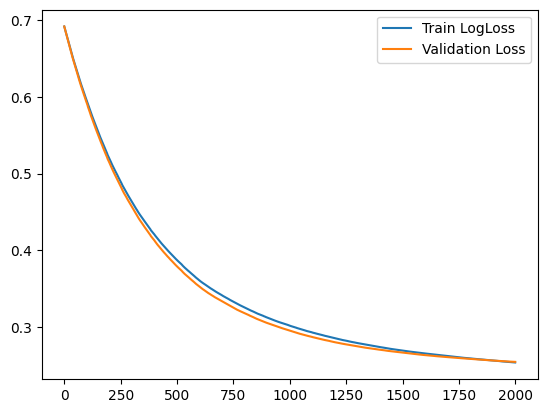

In [138]:
train_metric = evals['learn']['Logloss']
test_metric = evals['validation']['Logloss']

mat.pyplot.plot(train_metric, label= 'Train LogLoss')
mat.pyplot.plot(test_metric, label = 'Validation Loss')
mat.pyplot.legend()

In [140]:
print("Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Test PR  AUC:", average_precision_score(y_test, test_proba))
print("\nClassification report (Test):")
print(classification_report(y_test, test_pred, target_names=["No Revenue","Revenue"]))
print("\nConfusion matrix (Test):\n", confusion_matrix(y_test, test_pred))

# 3) (Optional) If you still want a "train" metric, evaluate on ORIGINAL train (pre-SMOTE):
train_proba_orig = catBoost.predict_proba(Pool(Xtr_enc))[:, 1]
train_pred_orig  = (train_proba_orig >= best_t).astype(int)
print("\nClassification report (Train, original non-resampled):")
print(classification_report(y_train, train_pred_orig, target_names=["No Revenue","Revenue"]))

Test ROC AUC: 0.9208843745917535
Test PR  AUC: 0.7261997964828609

Classification report (Test):
              precision    recall  f1-score   support

  No Revenue       0.95      0.92      0.93      2084
     Revenue       0.61      0.72      0.66       382

    accuracy                           0.89      2466
   macro avg       0.78      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466


Confusion matrix (Test):
 [[1910  174]
 [ 106  276]]

Classification report (Train, original non-resampled):
              precision    recall  f1-score   support

  No Revenue       0.95      0.92      0.94      8338
     Revenue       0.63      0.75      0.68      1526

    accuracy                           0.89      9864
   macro avg       0.79      0.84      0.81      9864
weighted avg       0.90      0.89      0.90      9864



In [139]:
learn_keys = list(evals['learn'].keys())
valid_keys = list(evals['validation'].keys())
key = (learn_keys[0] if learn_keys else None)

learn_curve = evals['learn'][key]
validation_curve = evals['validation'][key]

best_it = catBoost.get_best_iteration()
best_it = best_it if best_it is not None and best_it >= 0 else len(learn_curve)-1

train_metric = learn_curve[best_it]
val_metric   = validation_curve[best_it]
gap = val_metric - train_metric

print(f"=== CatBoost numeric fit report ===")
print(f"Metric key           : {key}")
print(f"Best iteration       : {best_it}")
print(f"Train {key} (best)   : {train_metric:.6f}")
print(f"Valid {key} (best)   : {val_metric:.6f}")
print(f"Generalization gap   : {gap:.6f}")

=== CatBoost numeric fit report ===
Metric key           : Logloss
Best iteration       : 1986
Train Logloss (best)   : 0.253638
Valid Logloss (best)   : 0.254337
Generalization gap   : 0.000699
